In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout


# !pip3 install -q torch torchvision
# !pip3 install -q Pillow==4.0.0

In [2]:
train_folder = "train"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

Number of files in the train folder 100


In [3]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
from pytorch_trainer import Trainer

import torch.nn as nn
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!
device

device(type='cuda', index=0)

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.list_dir = os.listdir(self.root_dir)
        
    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self, index):        
        img_name = os.path.join(self.root_dir, self.list_dir[index])
        img = Image.open(img_name).convert('RGB')

        if "badger" in self.list_dir[index]:
            label = 1
        else:
            label = 0

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [6]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [7]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2

val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [8]:
def accuracy(predictions, labels):
    indices = torch.argmax(predictions, dim=1)
    correct_samples = torch.sum(indices == labels)
    total_samples = len(labels)
    
    return float(correct_samples) / total_samples

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

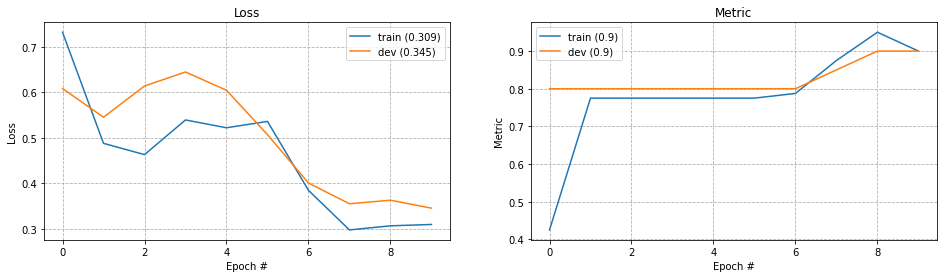

In [9]:

resnet_model = models.resnet18(pretrained=True).type(torch.cuda.FloatTensor)
device = torch.device("cuda:0")
resnet_model.to(device)

for param in resnet_model.parameters():
    param.requires_grad = False
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)

parameters = resnet_model.fc.parameters()   # Fill the right thing here!

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(parameters, lr=0.001, momentum=0.9)
trainer = Trainer(resnet_model, train_loader, val_loader)

trainer.train(opt=opt, 
              loss_fn=loss_fn, 
              metric_fn=accuracy, 
              device=device, 
              epochs=10)
# loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

In [37]:
from utils import evaluate_model
test_folder = "test"
# Count number of files in the train folder, should be 4603
print('Number of files in the test folder', len(os.listdir(test_folder)))

test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )


def evaluate_model(model, dataset):
    device = torch.device("cpu:0")
    model.eval()
    model.to(device)
    with torch.no_grad():
        loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
        images, labels = next(iter(loader))
        preds = model(images)
        _, classes  = torch.max(preds, dim=1)
        if classes[0] == 0:
            print("it is бурундук")
        else:
            print("It is барсук")

Number of files in the test folder 1


In [38]:
evaluate_model(resnet_model, test_dataset)

It is барсук
